# Mixed Layer Depth

In this notebook I'm diving into calculating the mixed layer depth based on the threshold method where the MLD is defined by a density change of $0.03 kg/m^3$ from the surface.

$ z_{mixed layer} = z_{\rho, surface} - z_{\rho, surface - 0.03 kg/m^2}$

Remember that we tried to load all of this information from `Argo_mixedlayers_all_04142022` which has both the threshold and hybrid method MLD for every profile in the Argo database as of April 2022. However, while this dataset has a unique profile number, the data downloaded from argopy does not have a unique identifier. It would probably be possible to match profiles based on the day/time they're collected, however this would likely be much more effor than its worth.

In [1]:
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
from importlib import reload
from cmocean import cm as cmo
import xrft
import pandas as pd


import density_funcs as df
import EV_funcs as ef
import filt_funcs as ff
import plot_funcs as pf

In [2]:
reload(df)
reload(ef)
reload(ff)
reload(pf);

In [3]:
box_z = xr.open_dataset("202206_boxes/lon:(60,70)_lat:(-60,-55)_ds_z.nc")
box_r = xr.open_dataset("202206_boxes/lon:(60,70)_lat:(-60,-55)_ds_rho.nc")

In [4]:
SIG0_surface = box_z.isel(N_PROF=100).SIG0.isel(PRES_INTERPOLATED=0)
SIG0_diff    = SIG0_surface + 0.03
z_s          = SIG0_surface.where(box_z.isel(N_PROF=100).SIG0<SIG0_diff)
MLD = z_s.dropna('PRES_INTERPOLATED').isel(PRES_INTERPOLATED=-1).PRES_INTERPOLATED.values

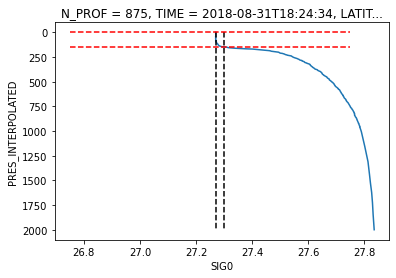

In [5]:
box_z.isel(N_PROF=100).SIG0.plot(y='PRES_INTERPOLATED')
plt.vlines(SIG0_surface,0,2000,linestyle='--',color='k')
plt.vlines(SIG0_diff   ,0,2000,linestyle='--',color='k')
plt.hlines(0,   26.75,27.75,linestyle='--',color='r')
plt.hlines(MLD, 26.75,27.75,linestyle='--',color='r')
plt.gca().invert_yaxis()

In [12]:
MLD_li = []

for n in range(0,len(box_z.N_PROF)):
    SIG0_surface = box_z.isel(N_PROF=n).SIG0.isel(PRES_INTERPOLATED=0)
    SIG0_diff    = SIG0_surface + 0.03
    MLD_ds       = SIG0_surface.where(box_z.isel(N_PROF=n).SIG0 < SIG0_diff)
    MLD          = MLD_ds.dropna('PRES_INTERPOLATED').isel(PRES_INTERPOLATED=-1).PRES_INTERPOLATED.values
    MLD_li.append(int(MLD))
    
box_z = box_z.assign_coords(MLD=('N_PROF',MLD_li))

In [13]:
def add_month(ds, variable='TIME'):
    
    ds['frac_day'] = ds.TIME.dt.day + (ds.TIME.dt.hour / 24) + (ds.TIME.dt.minute / (24*60)) + (ds.TIME.dt.minute / (24*60*60))
    ds['frac_month'] = ds.TIME.dt.month + (ds.frac_day / ds.TIME.dt.days_in_month)
    
    month_li = []
    for i in range(0,len(ds.N_PROF)):
        month_li.append(ds.isel(N_PROF=i).TIME.dt.month)
    
    return ds.assign_coords(month=('N_PROF',month_li))

In [14]:
def add_year(ds, variable='TIME'):
    
    ds['frac_day'] = ds.TIME.dt.day + (ds.TIME.dt.hour / 24) + (ds.TIME.dt.minute / (24*60)) + (ds.TIME.dt.minute / (24*60*60))
    ds['frac_month'] = ds.TIME.dt.month + (ds.frac_day / ds.TIME.dt.days_in_month)
    ds['frac_year'] = ds.TIME.dt.year + (ds.frac_month / 12)
    
    year_li = []
    for i in range(0,len(ds.N_PROF)):
        year_li.append(ds.isel(N_PROF=i).TIME.dt.year)
    
    return ds.assign_coords(year=('N_PROF',year_li))

In [15]:
box_z = add_month(box_z)
box_z = add_year(box_z)

box_zm = box_z.sortby('frac_month')
box_zy = box_z.sortby('frac_year')

In [16]:
SIG0_1  = box_z.SIG0.where(box_z.month<2)                         .dropna('N_PROF').mean('N_PROF')
SIG0_2  = box_z.SIG0.where(box_z.month<3).where(box_z.month>1)  .dropna('N_PROF').mean('N_PROF')
SIG0_3  = box_z.SIG0.where(box_z.month<4).where(box_z.month>2)  .dropna('N_PROF').mean('N_PROF')
SIG0_4  = box_z.SIG0.where(box_z.month<5).where(box_z.month>3)  .dropna('N_PROF').mean('N_PROF')
SIG0_5  = box_z.SIG0.where(box_z.month<6).where(box_z.month>4)  .dropna('N_PROF').mean('N_PROF')
SIG0_6  = box_z.SIG0.where(box_z.month<7).where(box_z.month>5)  .dropna('N_PROF').mean('N_PROF')
SIG0_7  = box_z.SIG0.where(box_z.month<8).where(box_z.month>6)  .dropna('N_PROF').mean('N_PROF')
SIG0_8  = box_z.SIG0.where(box_z.month<9).where(box_z.month>7)  .dropna('N_PROF').mean('N_PROF')
SIG0_9  = box_z.SIG0.where(box_z.month<10).where(box_z.month>8) .dropna('N_PROF').mean('N_PROF')
SIG0_10 = box_z.SIG0.where(box_z.month<11).where(box_z.month>9) .dropna('N_PROF').mean('N_PROF')
SIG0_11 = box_z.SIG0.where(box_z.month<12).where(box_z.month>10).dropna('N_PROF').mean('N_PROF')
SIG0_12 = box_z.SIG0.where(box_z.month<13).where(box_z.month>11).dropna('N_PROF').mean('N_PROF')

MLD_1  = box_z.MLD.where(box_z.month<2)                       .dropna('N_PROF').mean('N_PROF')
MLD_2  = box_z.MLD.where(box_z.month<3).where(box_z.month>1)  .dropna('N_PROF').mean('N_PROF')
MLD_3  = box_z.MLD.where(box_z.month<4).where(box_z.month>2)  .dropna('N_PROF').mean('N_PROF')
MLD_4  = box_z.MLD.where(box_z.month<5).where(box_z.month>3)  .dropna('N_PROF').mean('N_PROF')
MLD_5  = box_z.MLD.where(box_z.month<6).where(box_z.month>4)  .dropna('N_PROF').mean('N_PROF')
MLD_6  = box_z.MLD.where(box_z.month<7).where(box_z.month>5)  .dropna('N_PROF').mean('N_PROF')
MLD_7  = box_z.MLD.where(box_z.month<8).where(box_z.month>6)  .dropna('N_PROF').mean('N_PROF')
MLD_8  = box_z.MLD.where(box_z.month<9).where(box_z.month>7)  .dropna('N_PROF').mean('N_PROF')
MLD_9  = box_z.MLD.where(box_z.month<10).where(box_z.month>8) .dropna('N_PROF').mean('N_PROF')
MLD_10 = box_z.MLD.where(box_z.month<11).where(box_z.month>9) .dropna('N_PROF').mean('N_PROF')
MLD_11 = box_z.MLD.where(box_z.month<12).where(box_z.month>10).dropna('N_PROF').mean('N_PROF')
MLD_12 = box_z.MLD.where(box_z.month<13).where(box_z.month>11).dropna('N_PROF').mean('N_PROF')

In [19]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

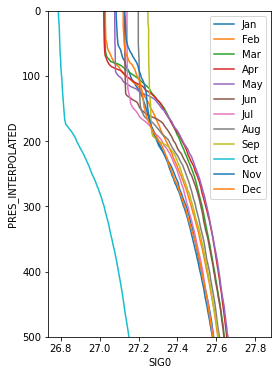

In [21]:
plt.figure(figsize=(4,6))
SIG0_1 .plot(y='PRES_INTERPOLATED',label=months[0])
SIG0_2 .plot(y='PRES_INTERPOLATED',label=months[1])
SIG0_3 .plot(y='PRES_INTERPOLATED',label=months[2])
SIG0_4 .plot(y='PRES_INTERPOLATED',label=months[3])
SIG0_5 .plot(y='PRES_INTERPOLATED',label=months[4])
SIG0_6 .plot(y='PRES_INTERPOLATED',label=months[5])
SIG0_7 .plot(y='PRES_INTERPOLATED',label=months[6])
SIG0_8 .plot(y='PRES_INTERPOLATED',label=months[7])
SIG0_9 .plot(y='PRES_INTERPOLATED',label=months[8])
SIG0_10.plot(y='PRES_INTERPOLATED',label=months[9])
SIG0_11.plot(y='PRES_INTERPOLATED',label=months[10])
SIG0_12.plot(y='PRES_INTERPOLATED',label=months[11])
plt.gca().invert_yaxis()
plt.ylim(500,0)
plt.legend()

Need to figure out how to plot the MLD as a point on the density curve. This requires an x coordinate (density at the mean MLD) and a y coordinate (MLD values calculated above). This means you'll need to find the closest interpolated pressure to MLD and see what density value is associated with this pressure.

Separate thought: look at all the profiles by season, is there some kind of coninuity? Or is this not really a valid data source because I've picked a float track, so we're not just looking at seasonality but also distance? I think you should redo the above analysis with a box instead, as I assume this is a better fit to study seasonality.